# Athens Airbnb Data

In [33]:
import pathlib
import pickle
import pandas as pd
import seaborn as sns

import utils

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [34]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
processed_file_path = DATA_DIR / 'processed' / 'data_athens.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)

In [35]:
data.head()

,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Restraunt Index,LogPrice,Price_per_GDP,LogPrice_per_GDP
2080,Athens,129.824479,Weekday,Entire home/apt,False,False,4.0,False,0.0,0.0,10,100,2.0,2.813964,0.881890,55.348572,78.778377,2.113357,0.006429,-2.191836
2081,Athens,138.963748,Weekday,Entire home/apt,False,False,4.0,True,1.0,0.0,10,96,1.0,0.407293,0.304568,240.306654,407.167696,2.142902,0.006882,-2.162291
2082,Athens,156.304923,Weekday,Entire home/apt,False,False,3.0,True,0.0,1.0,10,98,1.0,1.237211,0.288488,199.507366,395.967403,2.193973,0.007741,-2.111220
2083,Athens,91.627024,Weekday,Entire home/apt,False,False,4.0,True,1.0,0.0,10,99,1.0,4.367457,0.297467,39.803047,58.706578,1.962024,0.004538,-2.343169
2084,Athens,74.051508,Weekday,Private room,False,True,2.0,False,0.0,0.0,10,100,1.0,2.194185,0.385266,78.733405,113.325973,1.869534,0.003667,-2.435658


##### Treating Price Outliers 

<Axes: xlabel='LogPrice', ylabel='Density'>

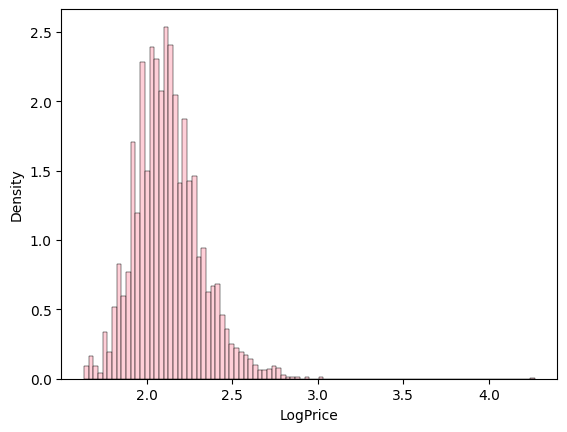

In [36]:
sns.histplot(data['LogPrice'], color = 'pink', stat="density")

In [37]:
q1=data['LogPrice'].quantile(.25)
q2=data['LogPrice'].quantile(.50)
q3=data['LogPrice'].quantile(.75)
iqr=q3-q1
print('first quartile is %.1f'%q1)
print('second quartile is %.1f'%q2)
print('third quartile is %.1f'%q3)
print('interquartile range is %.1f'%iqr)

limit_low=q1-iqr*1.999
limit_high=q3+iqr*1.999
print('lower limit is %.1f'%limit_low)
print('upper limit is %.1f'%limit_high)

first quartile is 2.0
second quartile is 2.1
third quartile is 2.2
interquartile range is 0.2
lower limit is 1.5
upper limit is 2.7


In [38]:
data = data[data['LogPrice'] < limit_high].copy()

<Axes: xlabel='LogPrice', ylabel='Count'>

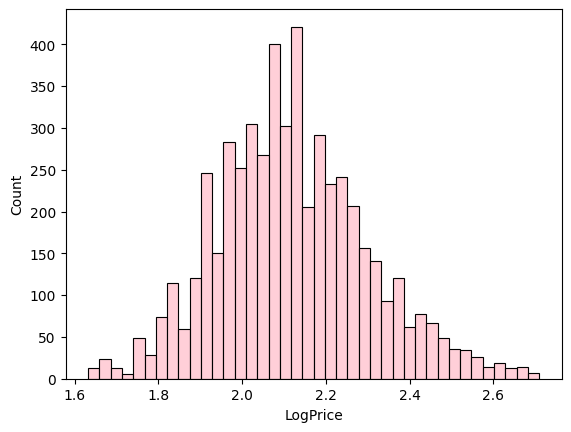

In [39]:
sns.histplot(data['LogPrice'], color = 'pink')

Limpando variaveis categoricas que não serão usadas nesta análise

In [40]:
cat_variables = categorical_variables
cat_variables.remove('City')

             count unique              top  freq
Day           5235      2          Weekday  2628
Room Type     5235      3  Entire home/apt  4837
Shared Room   5235      2            False  5224
Private Room  5235      2            False  4848
Superhost     5235      2            False  2988


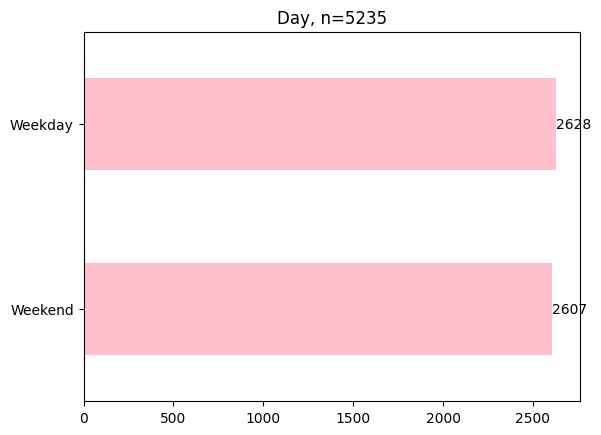

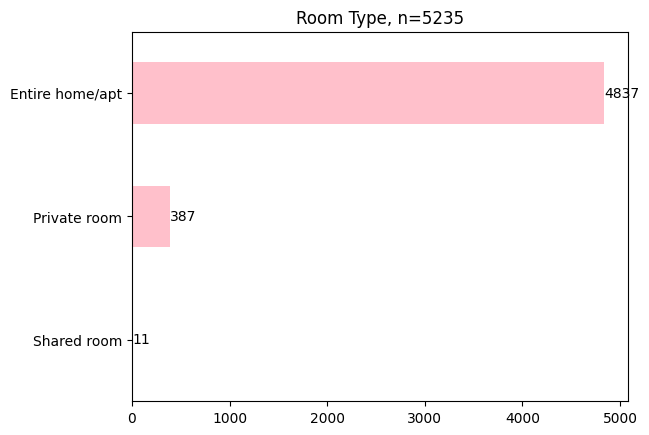

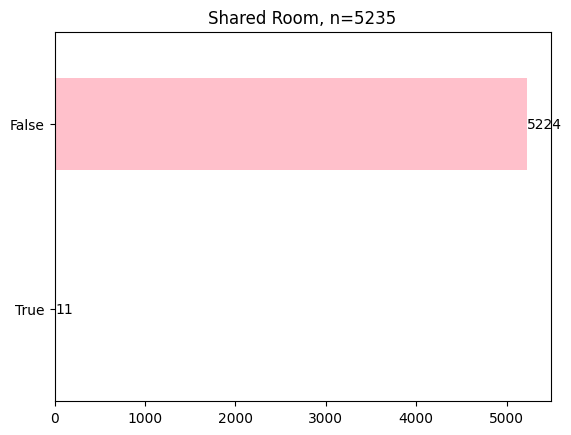

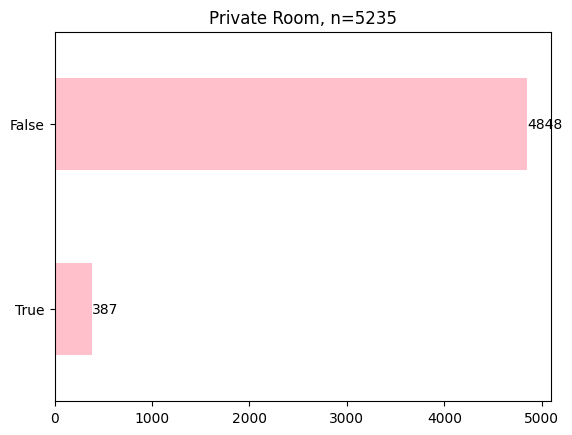

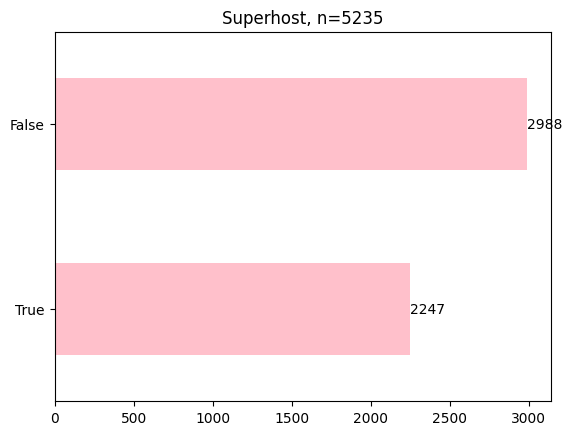

In [41]:
utils.plot_categoricals(data, cat_variables)

OBS: Quase não temos dados para shared rooms

DECISÃO: Remover airbnb que são do tipo shared rooms

In [42]:
data = data[data['Room Type'] != 'Shared room'].copy()
data.drop(columns = ['Shared Room'], inplace = True)

                  count      mean       std  min  25%  50%  75%  max
Person Capacity  5224.0  3.688744  1.277045  2.0  3.0  4.0  4.0  6.0
Multiple Rooms   5224.0  0.267611  0.442756  0.0  0.0  0.0  1.0  1.0
Business         5224.0  0.375957  0.484415  0.0  0.0  0.0  1.0  1.0
Bedrooms         5224.0  1.265505  0.647643  0.0  1.0  1.0  2.0  3.0


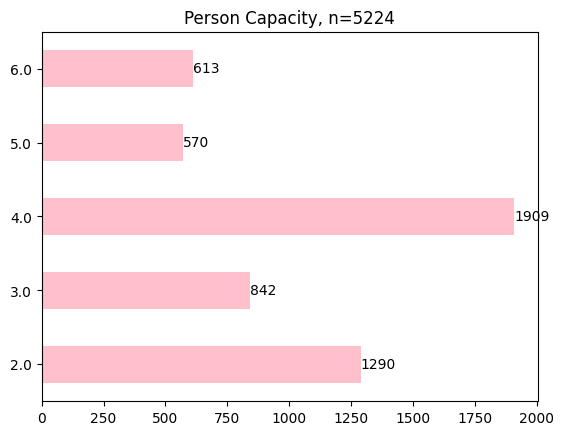

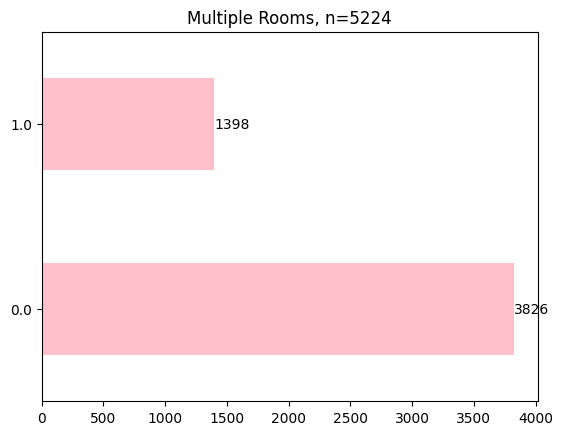

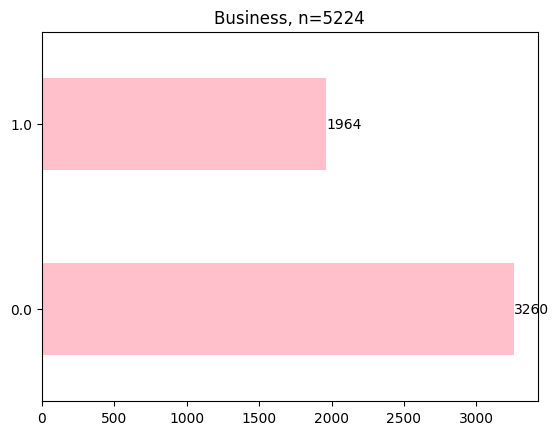

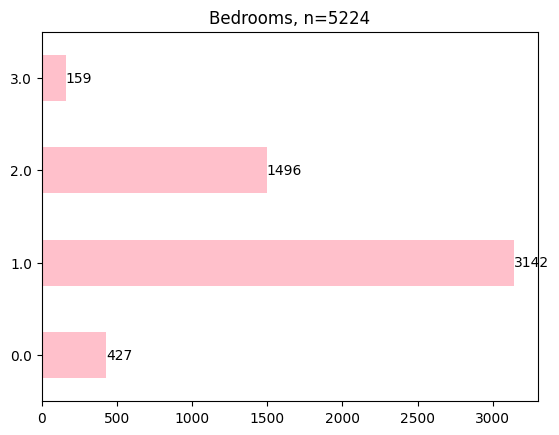

In [43]:
utils.plot_discretes(data, discrete_variables, sorted=False)

Limpando variaveis continuas que não serão usadas nesta análise

In [44]:
cat_continuous = continuous_variables
cat_continuous.remove('Normalised Attraction Index')
cat_continuous.remove('Normalised Restraunt Index')

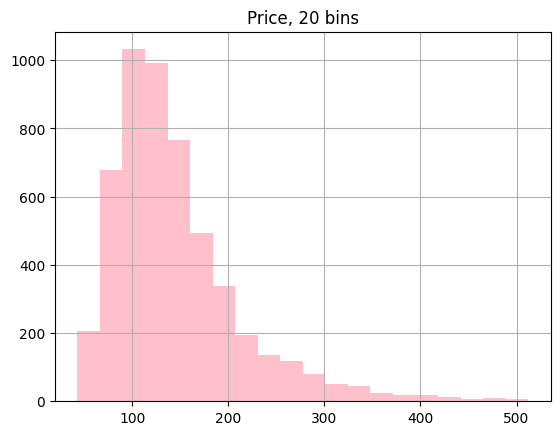

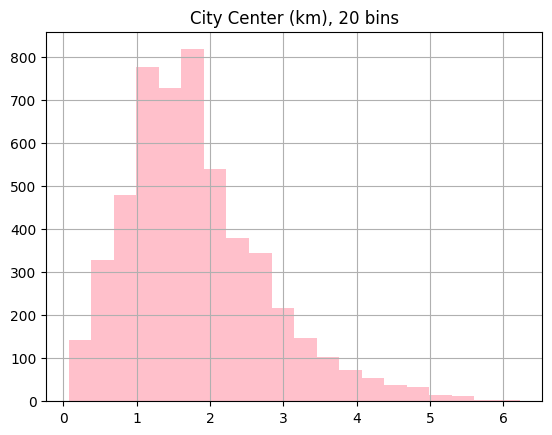

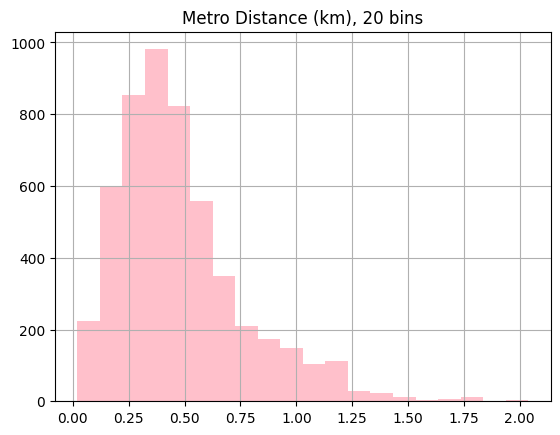

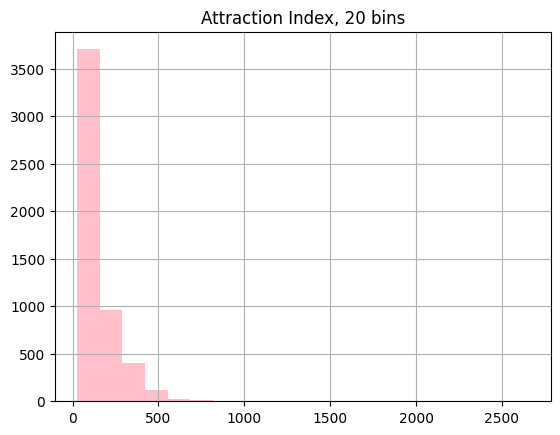

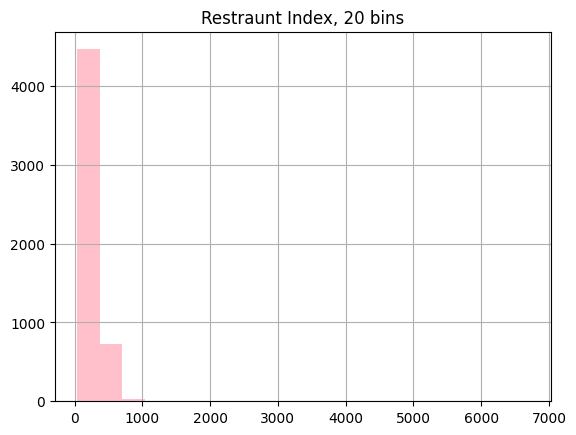

In [45]:
utils.plot_continuous(data, cat_continuous)

Vamos analisar dois tipos de airbnb separadamente, entire home/apt e private room, em buscada de identificar caracteristicas que influenciam o preço para cada um desses tipos. 

## Athens Entire home/apt

In [46]:
data_entire_homeapt = data.loc[data['Room Type'] == 'Entire home/apt'].copy()

<Axes: >

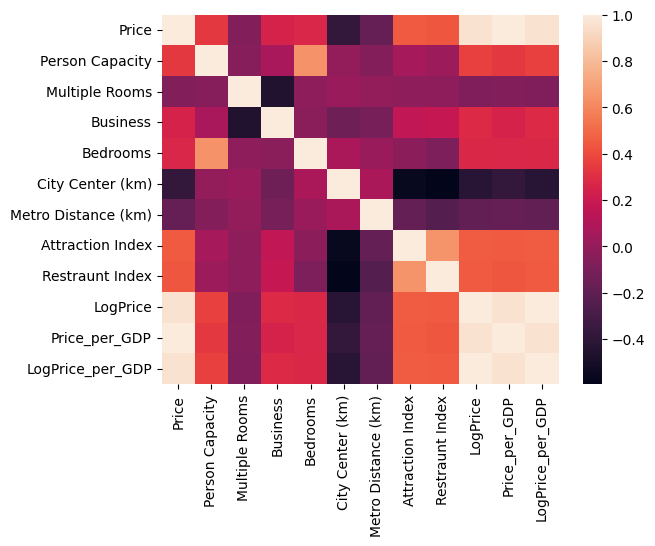

In [47]:
corr = data_entire_homeapt.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [48]:
corr['LogPrice'].sort_values()

City Center (km)      -0.423910
Metro Distance (km)   -0.191436
Multiple Rooms        -0.080053
Bedrooms               0.273548
Business               0.278298
Person Capacity        0.366759
Restraunt Index        0.445878
Attraction Index       0.451929
Price_per_GDP          0.961027
Price                  0.961027
LogPrice_per_GDP       1.000000
LogPrice               1.000000
Name: LogPrice, dtype: float64

#### Modelo - Lasso

In [49]:
data_entire_homeapt = pd.get_dummies(data_entire_homeapt, columns = ['City','Day','Private Room','Superhost'], drop_first = True)

In [50]:
features = data_entire_homeapt.drop(columns=['Price', 'LogPrice', 'Price_per_GDP', 'LogPrice_per_GDP', 'City_Athens', 'City_Barcelona','City_Berlin','City_Budapest','City_Lisbon','City_Paris','City_Rome','City_Vienna', 'Room Type']).copy()
target = data_entire_homeapt['LogPrice_per_GDP'].copy()

In [51]:
X = features
Y = target

In [52]:
# Dicionário vazio para armazenar os coeficientes
coeficientes_dict_entireHouseApt = {}

# Itere de 1 a 1001
for random_state in range(1, 1002):
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

    # Divida os dados de treinamento em conjuntos de treinamento e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

     # Crie uma instância do modelo de Lasso
    modeloAmsterdam_Lasso01 = Lasso(alpha=0.05)

    # Treine o modelo
    modeloAmsterdam_Lasso01.fit(X_train, y_train)

    # Obtenha os coeficientes
    coeficientes = dict(zip(modeloAmsterdam_Lasso01.feature_names_in_, modeloAmsterdam_Lasso01.coef_))
    
    # Atualize o dicionário de coeficientes
    for feature, coeficiente in coeficientes.items():
        if feature not in coeficientes_dict_entireHouseApt:
            coeficientes_dict_entireHouseApt[feature] = []
        coeficientes_dict_entireHouseApt[feature].append(coeficiente)

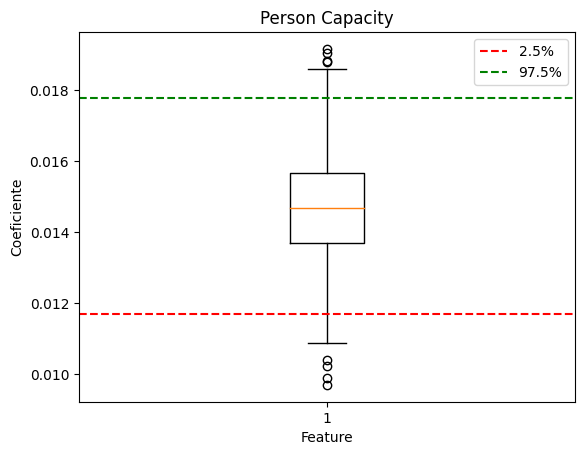

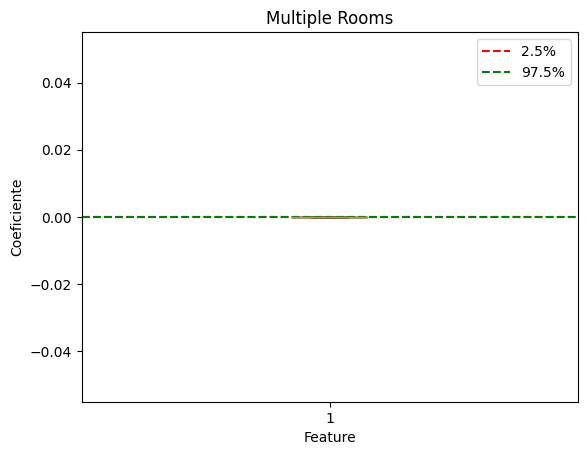

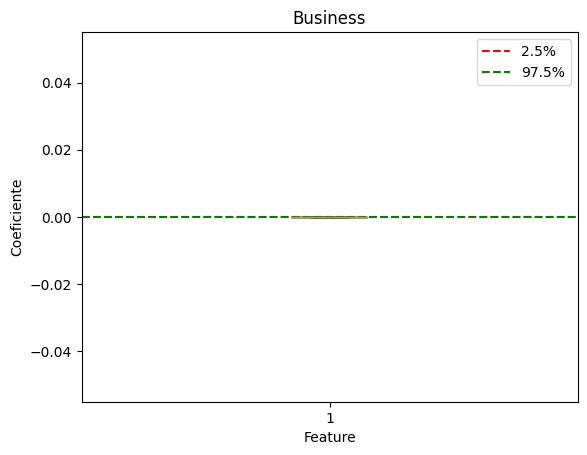

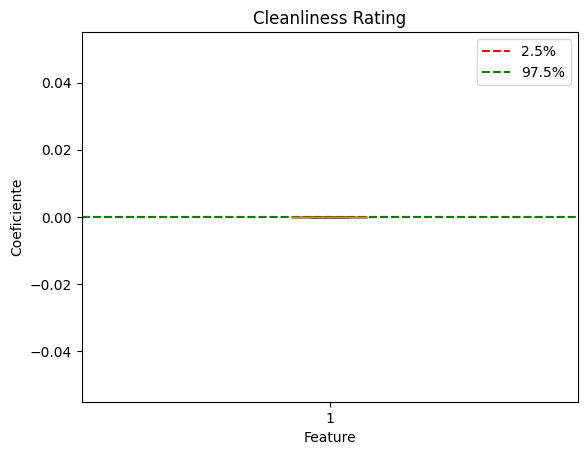

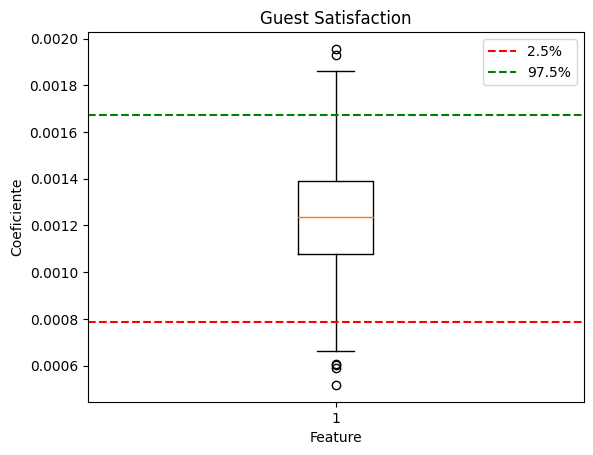

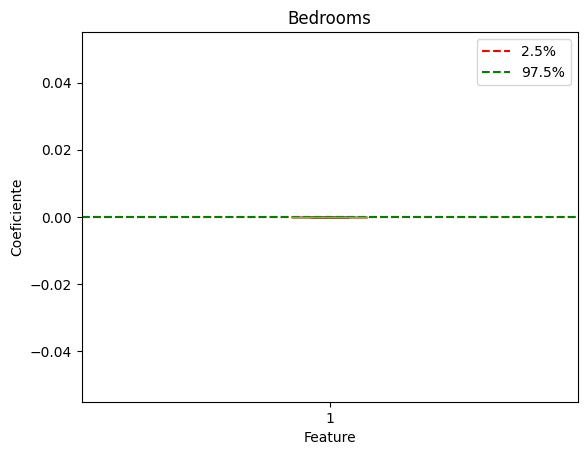

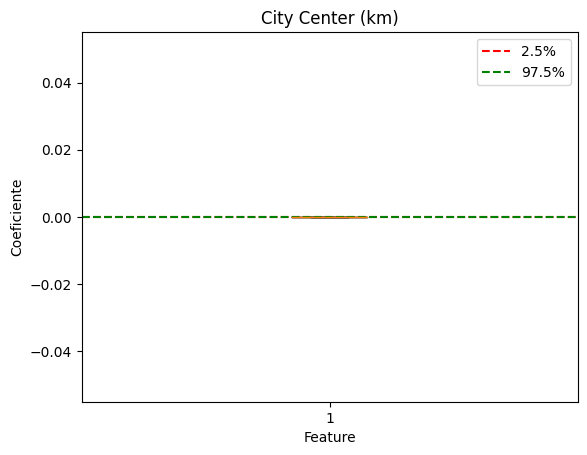

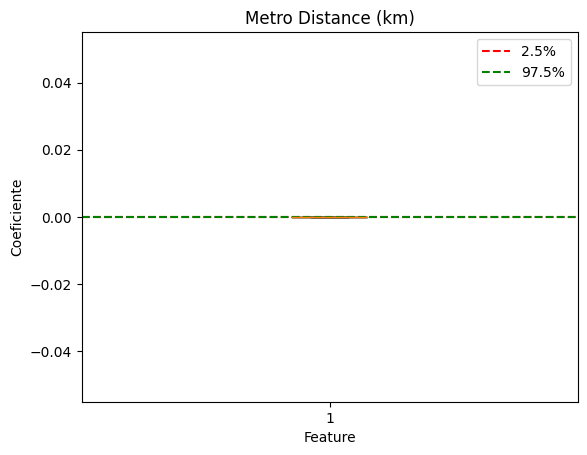

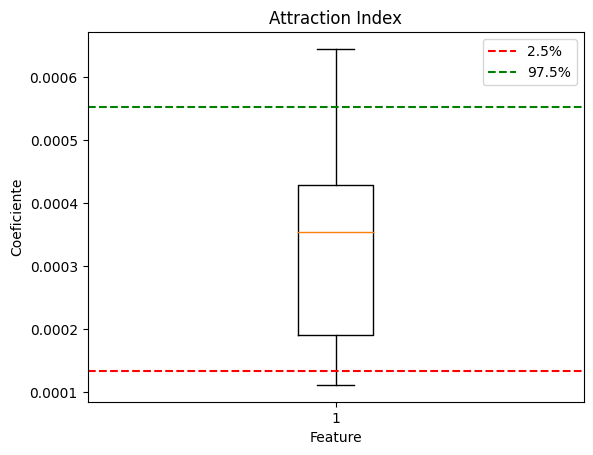

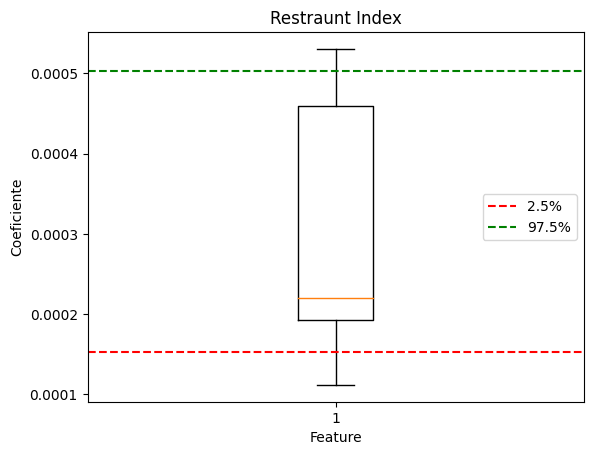

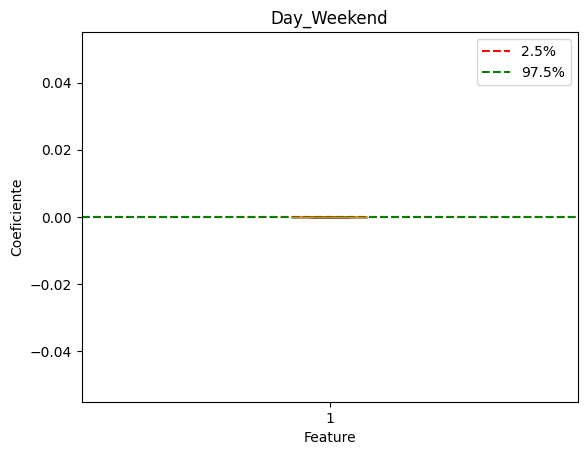

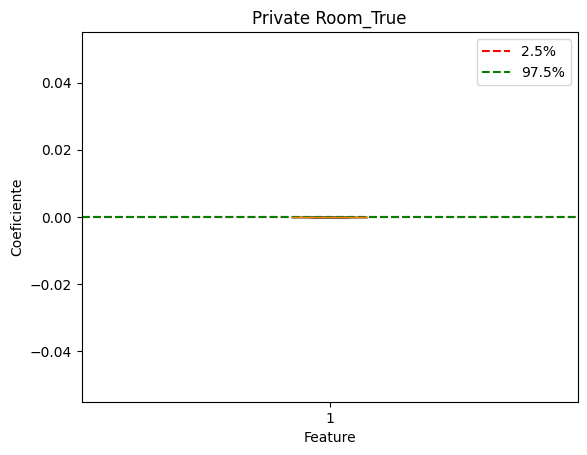

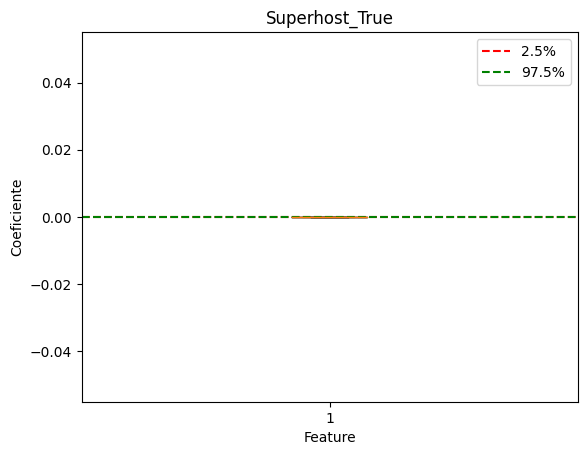

In [53]:
utils.plot_coefModeloLasso(coeficientes_dict_entireHouseApt)

## Athens Private room

In [54]:
data_private_room = data.loc[data['Room Type'] == 'Private room'].copy()

<Axes: >

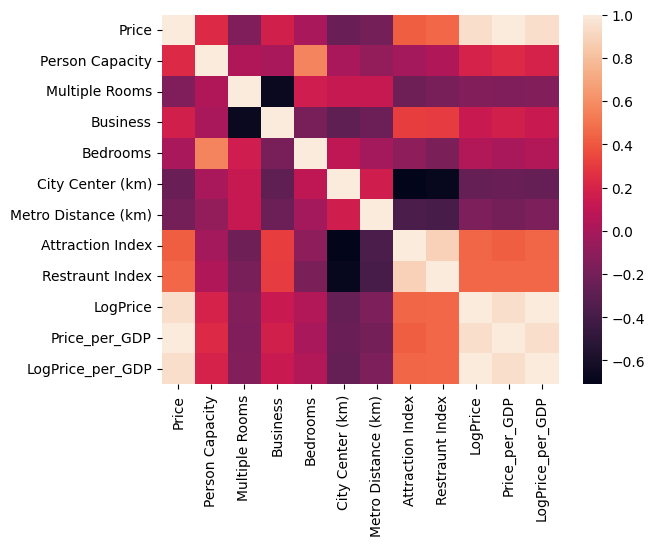

In [55]:
corr = data_private_room.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [56]:
corr['LogPrice'].sort_values()

City Center (km)      -0.257201
Metro Distance (km)   -0.162801
Multiple Rooms        -0.142694
Bedrooms               0.038874
Business               0.136102
Person Capacity        0.196123
Attraction Index       0.449843
Restraunt Index        0.456601
Price                  0.941718
Price_per_GDP          0.941718
LogPrice               1.000000
LogPrice_per_GDP       1.000000
Name: LogPrice, dtype: float64

In [57]:
data_private_room = pd.get_dummies(data_private_room, columns = ['City','Day','Private Room','Superhost'], drop_first = True)

In [58]:
features = data_private_room.drop(columns=['Price', 'LogPrice', 'Price_per_GDP', 'LogPrice_per_GDP', 'City_Athens', 'City_Barcelona','City_Berlin','City_Budapest','City_Lisbon','City_Paris','City_Rome','City_Vienna', 'Room Type']).copy()
target = data_private_room['LogPrice_per_GDP'].copy()

In [59]:
X = features
Y = target

In [60]:
# Dicionário vazio para armazenar os coeficientes
coeficientes_dict_privateRoom = {}

# Itere de 1 a 1001
for random_state in range(1, 1002):
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

    # Divida os dados de treinamento em conjuntos de treinamento e validação
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

     # Crie uma instância do modelo de Lasso
    modeloAmsterdam_Lasso01 = Lasso(alpha=0.05)

    # Treine o modelo
    modeloAmsterdam_Lasso01.fit(X_train, y_train)

    # Obtenha os coeficientes
    coeficientes = dict(zip(modeloAmsterdam_Lasso01.feature_names_in_, modeloAmsterdam_Lasso01.coef_))
    
    # Atualize o dicionário de coeficientes
    for feature, coeficiente in coeficientes.items():
        if feature not in coeficientes_dict_privateRoom:
            coeficientes_dict_privateRoom[feature] = []
        coeficientes_dict_privateRoom[feature].append(coeficiente)

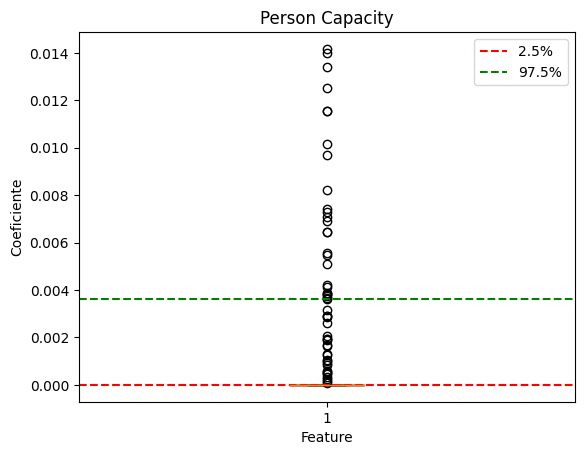

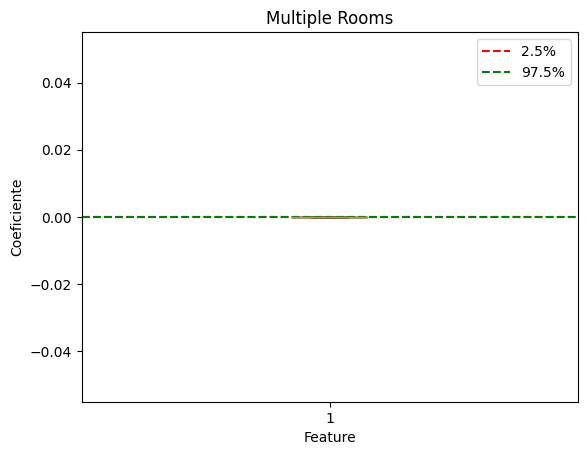

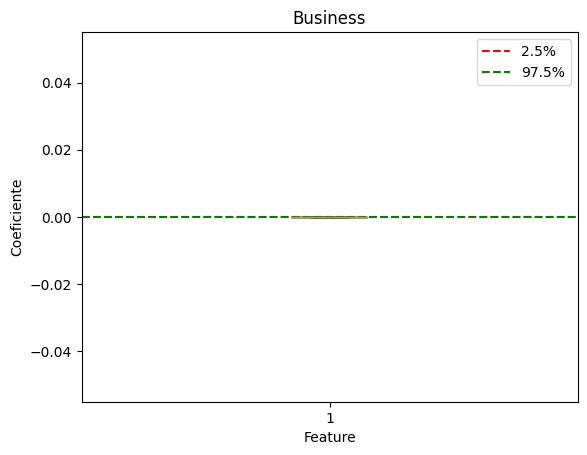

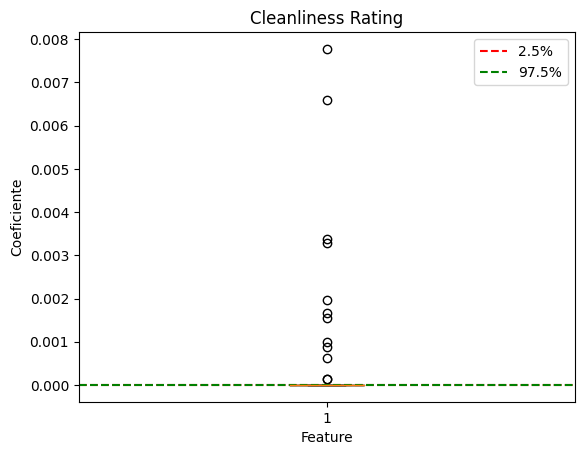

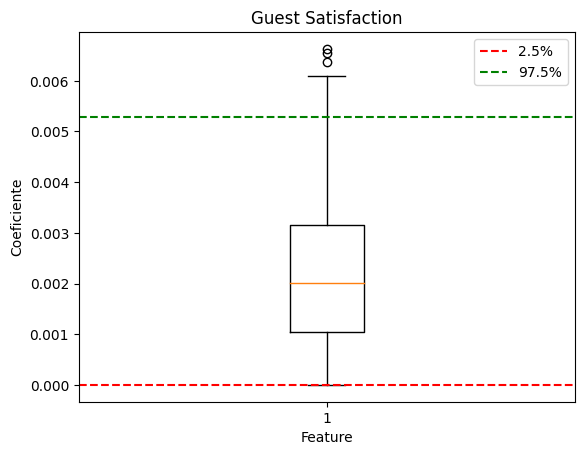

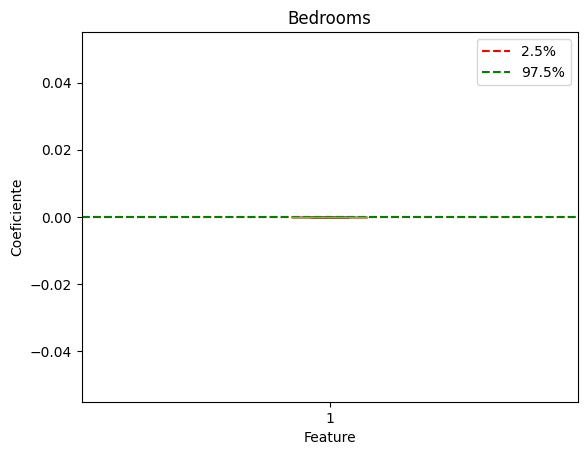

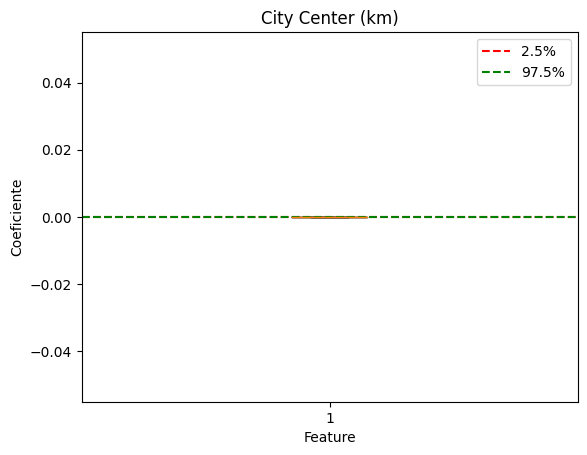

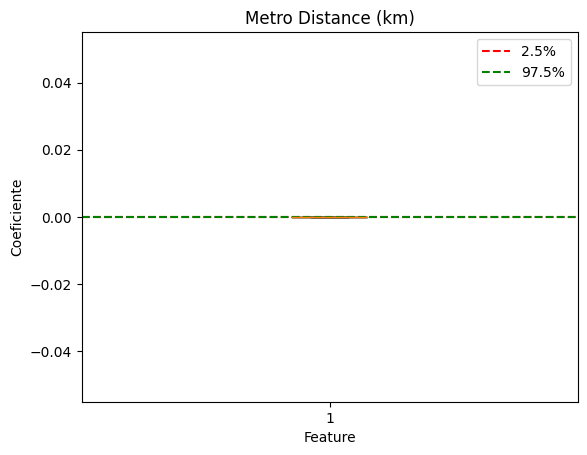

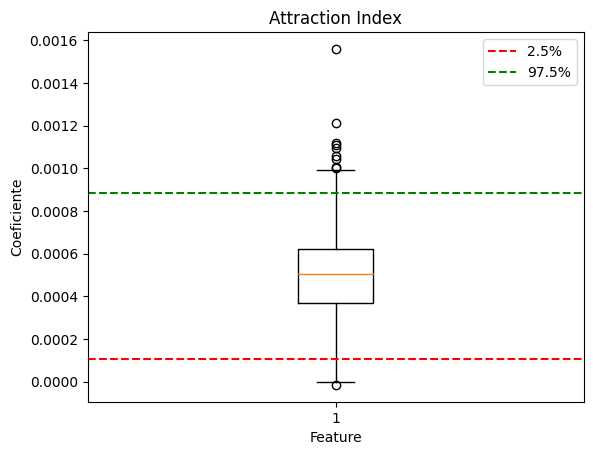

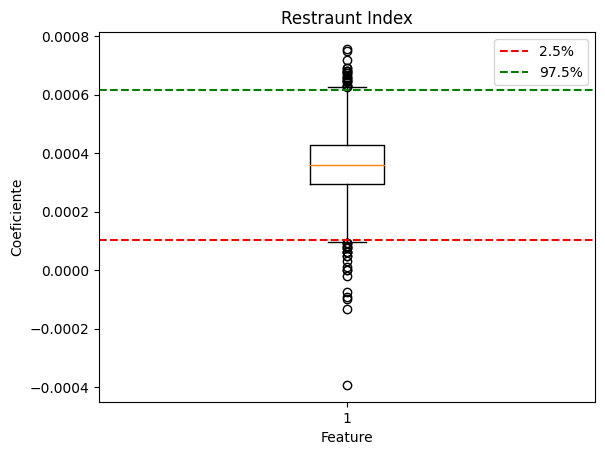

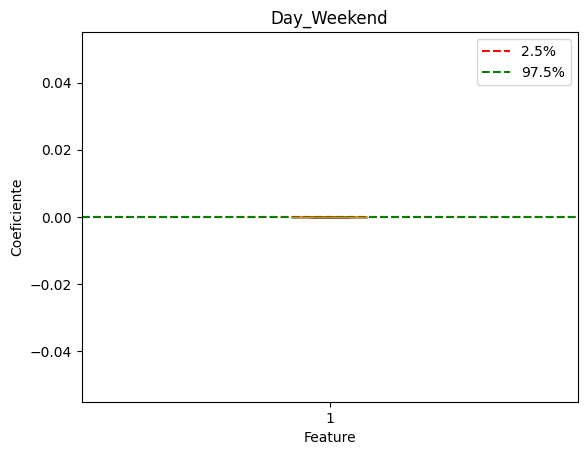

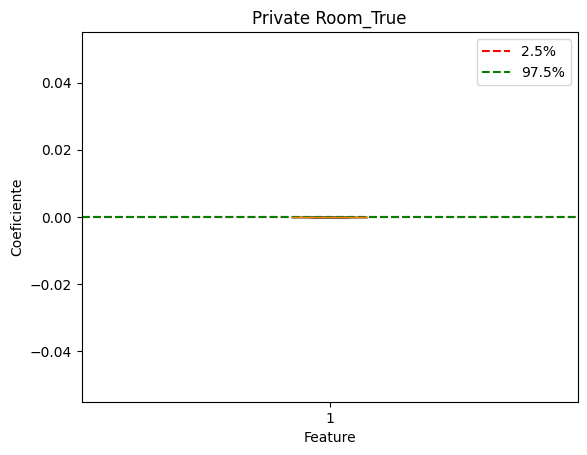

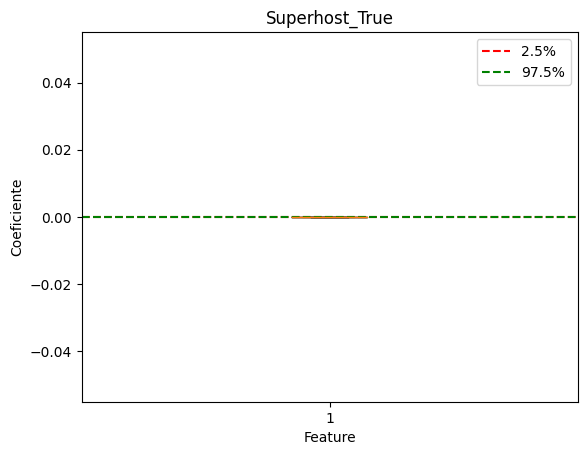

In [61]:
utils.plot_coefModeloLasso(coeficientes_dict_privateRoom)

In [62]:
DATA_DIR = pathlib.Path.cwd().parent / 'data' /'processed'
print(DATA_DIR)

c:\Users\sarah\Documents\6sem\MachineLearning\projeto\AirbnbPrice_Prediction\data\processed


In [63]:
processed_file_path = DATA_DIR / 'athens_coefficient.pkl'

In [64]:
with open(processed_file_path, 'wb') as file:
    pickle.dump(
        [
            data,
            coeficientes_dict_entireHouseApt,
            coeficientes_dict_privateRoom,
        ],
        file,
    )